# Compare ECCOv4r4 and ADCP zonal velocity at 140W, 75m depth

In [2]:
from datetime import datetime,timedelta
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from xmitgcm import open_mdsdataset
from MITgcmutils import rdmds, wrmds
import pych.ecco as pe
import ecco_v4_py as ecco
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
from matplotlib import rc
from scipy import stats

from pych.plot import nice_inward_ticks

In [3]:
plt.rcParams.update({'font.size':18,'axes.labelsize':18,'axes.titlesize':22,'text.usetex':True})
rc('text.latex', preamble=r'\usepackage{color}')

### Load up the ECCO output files and make dataset

In [4]:
uvel = xr.open_dataarray('../ncfiles/eccov4r4_uvel.nc')
vvel = xr.open_dataarray('../ncfiles/eccov4r4_vvel.nc')

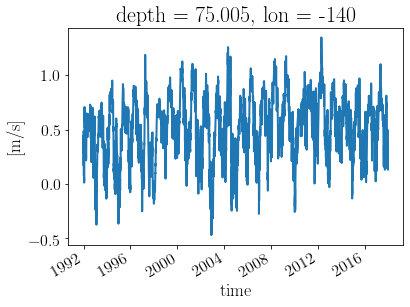

In [5]:
uvel.sel(lon=-140).sel(depth=75,method='nearest').plot()

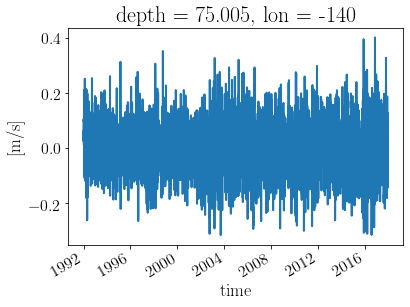

In [6]:
vvel.sel(lon=-140).sel(depth=75,method='nearest').plot()

In [7]:
eds = xr.Dataset({'uvel':uvel,'vvel':vvel})

In [8]:
eds = eds.sel(lon=-140).sel(depth=75,method='nearest')

In [9]:
def convert_units(ds):
    for fld in ds.data_vars:
        if ds[fld].attrs['units']=='m/s':
            with xr.set_options(keep_attrs=True):
                ds[fld] = ds[fld]*100
                ds[fld].attrs['units'] = 'cm/s'
    return ds

In [10]:
eds = convert_units(eds)

### Load up ADCP dataset

In [11]:
adcp = xr.open_dataset('/mnt/data/datasets/tao_triton/adcp0n140w_hr.cdf')
adcp = adcp.sel(lon=220,lat=0,depth=75)
adcp = adcp.rename({'u_1205':'uvel','v_1206':'vvel'})

In [12]:
def replace_nans(ds,fld):
    atts = ds[fld].attrs
    xda = xr.where(ds[fld]==ds.missing_value,np.NAN,ds[fld])
    xda.attrs=atts
    return xda

In [13]:
with xr.set_options(keep_attrs=True):
    for f in adcp.data_vars:
        adcp[f] = replace_nans(adcp,f)

In [14]:
fake_for_xaxis = xr.where(np.isnan(adcp.uvel),0.,adcp.uvel)

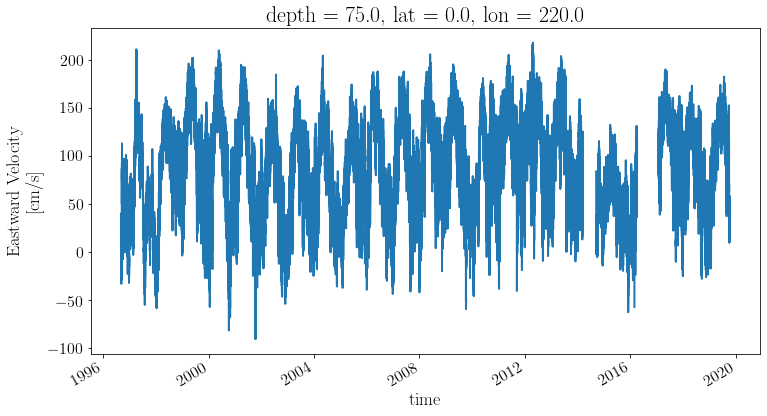

In [15]:
fig,ax = plt.subplots(figsize=(12,6))
adcp.uvel.plot()

## Find longest running time series from ADCP data with <3 day gap

In [16]:
gap_cumsum = (1*np.isnan(adcp.uvel)).cumsum('time')
#gap_threshold = gap_cumsum-gap_cumsum.shift(time=1)

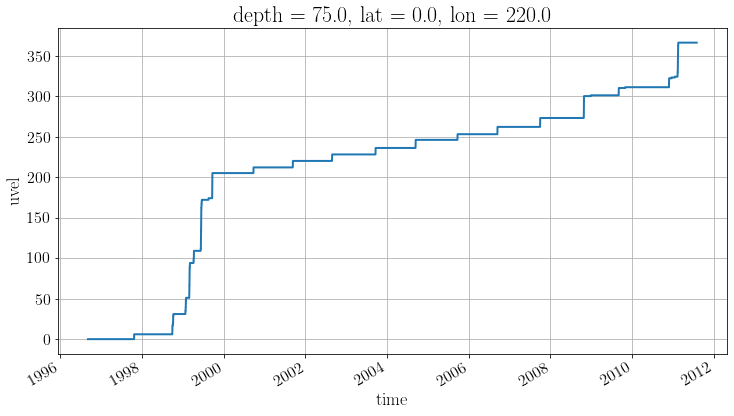

In [17]:
fig,ax = plt.subplots(figsize=(12,6))
tslice = slice('1996','2011-08-01')
gap_cumsum.sel(time=tslice).plot()
ax.grid();

In [18]:
36*3

108

In [19]:
adcp.time[0].values

numpy.datetime64('1996-09-04T01:00:00.000000000')

- big gap in about May 2014
- another gap ~August 2011
- by visual inspection, easy to see 1996-Sept-4 1AM to 2011-Aug-01 12AM, no gap bigger than 3 days

### Linearly interpolate in this time frame

In [20]:
for f in ['uvel','vvel']:
    adcp[f] = adcp[f].sel(time=tslice)
    eds[f] = eds[f].sel(time=tslice)

In [21]:
adcp['uvel_interp'] = adcp.uvel.interpolate_na('time')
adcp['vvel_interp'] = adcp.vvel.interpolate_na('time')

### Get the two only at the same time stamps

In [22]:
time_match = adcp.dropna('time').time==eds.dropna('time').time
Nt = time_match.sum()
for f in ['uvel','vvel']:
    eds[f] = eds[f].where(time_match).dropna('time')
    adcp[f] = adcp[f].where(time_match).dropna('time')

In [23]:
eds = eds.dropna('time')
adcp = adcp.dropna('time')

In [24]:
tablestuff=[]
for fld in ['uvel','vvel']:
    # do some computations for table
    diff_squared = (adcp[fld]-eds[fld])**2
    rmsdstr = '%.2f' % np.sqrt( diff_squared.sum()/Nt )
    for ds,rmsd in zip([adcp,eds],[rmsdstr,None]):
        comps =  ['%.2f' % ds[fld].mean().values,
                  '%.2f' % ds[fld].min().values,
                  '%.2f' % ds[fld].max().values,
                  '%.2f' % ds[fld].std().values,
                  '%.2f' % stats.skew(ds[fld].values,nan_policy='omit'),
                  '%.2f' % stats.kurtosis(ds[fld].values,nan_policy='omit'),
                  rmsd] # last for RMSD ... coming soon
        tablestuff.append(comps)

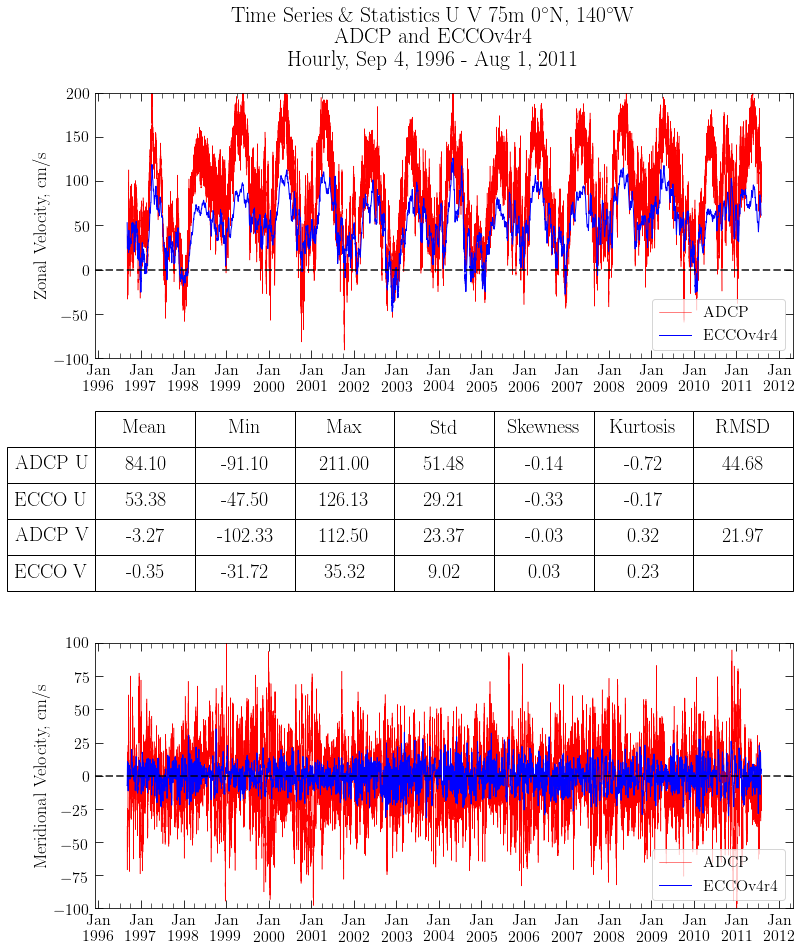

In [25]:
fig,axs = plt.subplots(3,1,figsize=(6.25*2,2.5*6),
                       gridspec_kw={
                           'height_ratios': [1.75,1.25, 1.75]})

for fld,ax,lbl,ylim in zip(['uvel','vvel'],
                           axs[[0,2]],
                           ['Zonal Velocity, cm/s','Meridional Velocity, cm/s'],
                          [[-100,200],[-100,100]]):
    adcp[fld].plot(ax=ax,color='red',label='ADCP',linewidth=.5)
    eds[fld].sel(time=tslice).plot(ax=ax,color='blue',label='ECCOv4r4',linewidth=1)

    # add line at y=0
    ax.axhline(y=0,alpha=.7,color='black',linestyle='--')
    
    # Plot formatting
    ax.set(xlabel='',ylabel=lbl,
           ylim=ylim,#xlim=["1996-01-01","1998-12-31"],
           title='')

    # Date formatting for x-axis
    date_form = DateFormatter("%b \n%Y")
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(date_form)
    
    ax.tick_params(direction='in',which='major',length=8,top=True,right=True,pad=6)
    ax.tick_params(direction='in',which='minor',length=5,top=True,right=True,pad=6)
    ax.legend(loc='lower right')
    #ax.set_xticklabels([])
    #ax.set_xticklabels(['','','Oct','','','','','Apr','','','Jul']*3,minor=True)
    for label in ax.xaxis.get_ticklabels():
        label.set_horizontalalignment('center')
        label.set_rotation(0)
    
columns = ['Mean','Min','Max','Std','Skewness','Kurtosis','RMSD']
table = axs[1].table(tablestuff,
             rowLabels=['ADCP U','ECCO U','ADCP V','ECCO V'],colLabels=columns,
             loc='center',rowLoc='center',cellLoc='center')
axs[1].axis('off')
table.set_fontsize(20)
table.scale(1, 3)

fig.suptitle(r'Time Series \& Statistics U V 75m 0$^\circ$N, 140$^\circ$W' + \
             '\nADCP and ECCOv4r4'+'\nHourly, Sep 4, 1996 - Aug 1, 2011',y=.96);
#fig.savefig('../figures/adcp_eccov4r4_hourly_140w_75m_1996-2000.png')

## Regression

In [26]:
from scipy import stats

In [27]:
def regress_plot(dsx,dsy,fldleft='uvel',fldright='vvel',
                 resample=None):
    nrows=2
    fig,axs = plt.subplots(1,2,figsize=(18,5))
    for i,(fld, ax,lbl,lbl2) in enumerate(zip([fldleft,fldright],axs,['U','V'],['Zonal','Meridional'])):
        if resample is not None:
            x = dsx[fld].resample({'time':resample}).mean().dropna('time')
            y = dsy[fld].resample({'time':resample}).mean().dropna('time')
        else:
            x = dsx[fld]
            y = dsy[fld]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        ax.scatter(x,y,marker='.',color=[.6, .6, .6],alpha=.9)
        ax.plot(x,slope*x+intercept,color='black',linewidth=1.5)
    
        mytext = f'r = {r_value:.2f}, p-val = {p_value:.2e}, y = {slope:.2f}x + {intercept:.2f}'
        if p_value<.025:
            mytext += '\nSlope of least-squares regression is significant with 95\% confidence'
        else:
            mytext += '\nSlope of least-squares regression is not significant with 95\% confidence'
        
        plt.figtext(.5,-.3,mytext,transform=ax.transAxes,
               horizontalalignment='center',bbox={'boxstyle':'round','facecolor':'white'})
        
        vmin = np.min([x.min().values,y.min().values])
        vmax = np.max([x.max().values,y.max().values])
        plot_lim = [vmin-.05*(vmax-vmin),vmax+.05*(vmax-vmin)]
        
        if resample =='1m':
            timestr = 'Monthly mean'
        elif resample is None:
            timestr = 'Hourly'
        ax.set(xlim=plot_lim,ylim=plot_lim,
               xlabel=f'ADCP {lbl} ({dsx[fld].attrs["units"]})',ylabel=f'ECCOv4r4 {lbl} ({dsy[fld].attrs["units"]})',
               title=f'{lbl} velocity at 0$^\circ$N, 140$^\circ$W at 75m depth\nECCOv4r4 -vs- ADCP\n{timestr}, Sep 4 1996 - Aug 1 2011')
        
    

    nice_inward_ticks(ax=axs[0],xminor_skip=5,yminor_skip=5)
    nice_inward_ticks(ax=axs[1],xminor_skip=2,yminor_skip=.5)
#fig.savefig('../figures/eccov4r4_adcp_regress_uv_monthly_75m_140w.png',bbox_inches='tight',dpi=300)

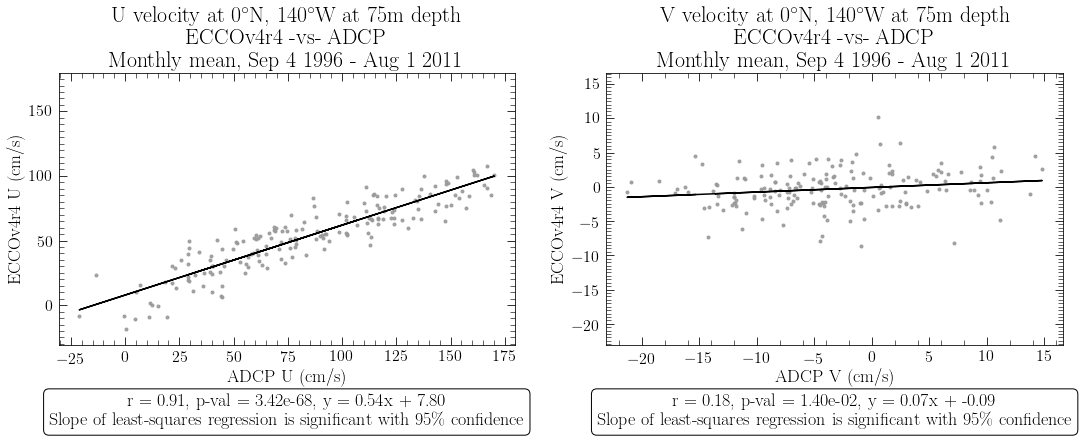

In [28]:
regress_plot(adcp,eds,resample='1m')

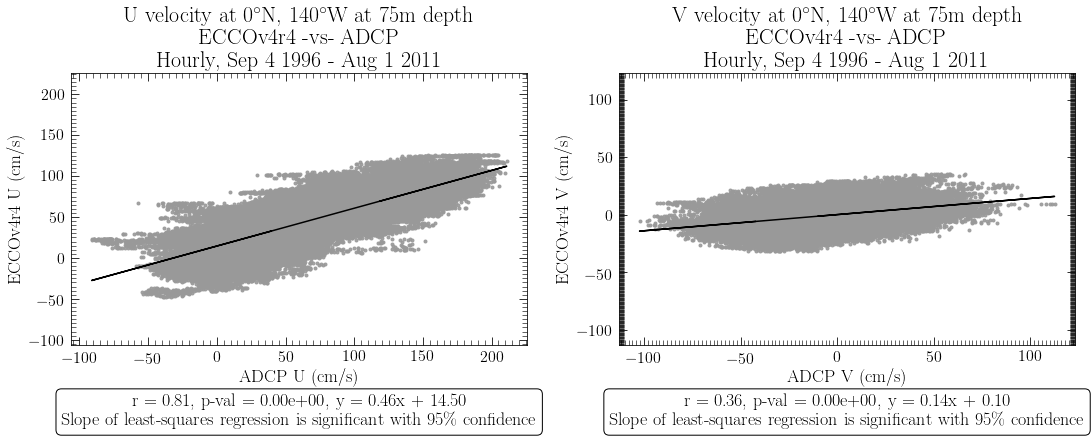

In [29]:
regress_plot(adcp,eds)

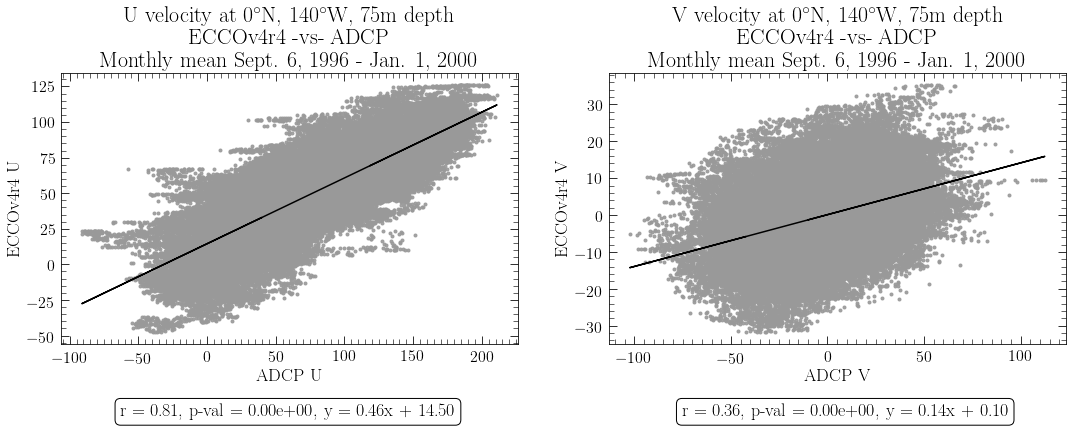

In [30]:
nrows=2
fig,axs = plt.subplots(1,2,figsize=(18,5))
#for fld, ax,xi,yi in zip(['uvel','vvel'],axs,[167,85],[-15,-23]):
for fld, ax,xi,yi,lbl,lbl2 in zip(['uvel','vvel'],axs,[.3,.73],[-.075,-.075],['U','V'],['Zonal','Meridional']):
    x = adcp[fld].dropna('time')
    y = eds[fld].dropna('time')
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    ax.scatter(x,y,marker='.',color=[.6, .6, .6],alpha=.9)
    ax.plot(x,slope*x+intercept,color='black',linewidth=1.5)
    plt.figtext(xi,yi,f'r = {r_value:.2f}, p-val = {p_value:.2e}, y = {slope:.2f}x + {intercept:.2f}',
           horizontalalignment='center',bbox={'boxstyle':'round','facecolor':'white'})
    ax.set(xlabel=f'ADCP {lbl}',ylabel=f'ECCOv4r4 {lbl}',
           title=f'{lbl} velocity at 0$^\circ$N, 140$^\circ$W, 75m depth\nECCOv4r4 -vs- ADCP\nMonthly mean Sept. 6, 1996 - Jan. 1, 2000')

nice_inward_ticks(ax=axs[0],xminor_skip=5,yminor_skip=5)
nice_inward_ticks(ax=axs[1],xminor_skip=5,yminor_skip=2)
fig.savefig('../figures/eccov4r4_adcp_regress_uv_hourly_75m_140w.png',bbox_inches='tight',dpi=300)